# Example 1: Simple DISV Voronoi model

##### To avoid confusion of the different IDs used: 
- Each model grid cell has an id (Cellid)
- If the cell has a UZF object, this UZF object will have another id (UZF_IFNO).
- If the cell has an SFR object, this SFR object will have another id (SFR_IFNO).
- The provider objects are always UZF objects (UZF cells).
- The receiver objects are either UZF cells or SFR reaches and can also be objects of other packages (e.g. LAK, WEL, etc).

##### The main steps to calculate the flow fractions are the following:
1. Load the discretization package and export the grid to a shapefile.
2. Load the provider package (UZF package) with the Cellid and the IFNO of each provider (UZF cell).
3. Get the neighbour cells to each grid cell.
4. Get the Cellid and IFNO of the receivers (UZF cells).
5. Calculate the distance between each cell and all its neighbour (connected) cells.
6. Calculate the slope between each cell and all its neighbour (connected) cells.
7. Sum the slopes of all neighbour (connected) cells to each cell.
8. Calculate the flow fraction from each cell to all its neighbour (connected) cells.
9. Adapt the calculations to the MOVER (MVR) package format.
10. Change the ID of the receivers in case the receivers are not UZF cells (e.g. SFR reaches).

In [1]:
import os
import sys
import shutil
import flopy
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
startTime = datetime.now()

#### Setup the working directory

In [3]:
root = os.path.join('.')
foldername = 'ex1_DISV_simple_voronoi'
model_ws = os.path.join(root, foldername)
shapefiles_ws = os.path.join(root, 'shapefiles')
if not os.path.exists(shapefiles_ws):
    os.makedirs(shapefiles_ws)

In [4]:
sim_name = 'mfsim.nam'
exe_name = os.path.join(model_ws, 'mf6')
sim = flopy.mf6.MFSimulation.load(sim_name = sim_name, version= 'mf6', exe_name = exe_name, sim_ws = model_ws)
gwf = sim.get_model(sim.model_names[0])

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package uzf...
    loading package sfr...
    loading package mvr...
    loading package oc...
  loading solution package transient...


#### 1. Load the discretization package and export the grid to a shapefile

In [5]:
# the next line works with whatever discretization package is used (DIS, DISV, DISU)
gwf.dis

# activate the below if you want to define the crs
'''
crs = gwf.modelgrid.crs
if crs is None:
    crs = 32734
    gwf.modelgrid.crs = crs
'''    

'\ncrs = gwf.modelgrid.crs\nif crs is None:\n    crs = 32734\n    gwf.modelgrid.crs = crs\n'

In [6]:
# export grid to shapefile
gridshp = gwf.dis.export(os.path.join(shapefiles_ws, 'grid_ex1.shp'))
# read the exported shapefile in a geopandas format
gridshp = gpd.read_file(os.path.join(root, 'shapefiles', 'grid_ex1.shp'))

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


C:\Users\DaoudMGM\Anaconda3\envs\Work\lib\site-packages\flopy\mf6\mfbase.py:468: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


<Axes: >

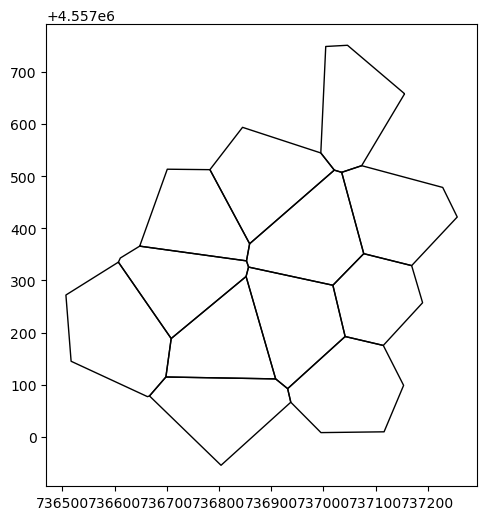

In [7]:
fig, ax = plt.subplots(figsize = (8, 6)) 
gridshp.plot(ax = ax, facecolor = "none")

In [8]:
# make a copy of the geometry column (will be needed later to get the connected cells to each cell)
gridshp['geometry2'] = gridshp['geometry']

#### 2. Load the provider package (UZF package) with the Cellid and the IFNO of each provider (UZF cell) 
##### Add the Cellid and the IFNO to the model grid shapefile

In [9]:
# Get the ifno and cell id of the UZF package and add 1 to all the numbers (since Python is zero-based)
uzf_packagedata = gwf.uzf.packagedata.get_data()
uzf_ifno = uzf_packagedata.ifno + (1)
cellid_0 = uzf_packagedata.cellid
cellid = []

if len(cellid_0[0]) == 1:          # in case of DISU package
    for id in cellid_0:
        id = list(id)
        id[0] = id[0] + 1
        id = tuple(id)
        cellid.append((id))    
elif len(cellid_0[0]) == 2:         # in case of DISV package
    for nlay, id in cellid_0:
        nlay = nlay + 1
        id = id + 1
        cellid.append((nlay, id))
else:                               # in case of DIS package
    for nlay, nrow, ncol in cellid_0:
        nlay = nlay + 1
        nrow = nrow + 1
        ncol = ncol + 1
        cellid.append((nlay, nrow, ncol))     

In [10]:
# add the UZF data (ifno, cellid) to the model grid geopandas
uzf_data = pd.DataFrame([uzf_ifno, cellid]).T
gridshp["uzf_ifno"] = uzf_data[0]
gridshp["cellid"] = uzf_data[1]
gridshp.head()

,node,botm_1,botm_2,idomain_1,idomain_2,top,geometry,geometry2,uzf_ifno,cellid
0,1,767.49,747.49,1,1,777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...","POLYGON ((737018.305 4557290.880, 737041.804 4...",1,"(1, 1)"
1,2,765.00,745.00,1,1,774.996,"POLYGON ((737041.804 4557192.650, 737114.917 4...","POLYGON ((737041.804 4557192.650, 737114.917 4...",2,"(1, 2)"
2,3,761.85,751.85,1,1,781.849,"POLYGON ((737073.449 4557520.000, 737228.780 4...","POLYGON ((737073.449 4557520.000, 737228.780 4...",3,"(1, 3)"
3,4,773.41,743.41,1,1,785.457,"POLYGON ((737155.745 4557657.800, 737073.449 4...","POLYGON ((737155.745 4557657.800, 737073.449 4...",4,"(1, 4)"
4,5,778.25,748.25,1,1,778.249,"POLYGON ((737041.804 4557192.650, 737018.305 4...","POLYGON ((737041.804 4557192.650, 737018.305 4...",5,"(1, 5)"


#### 3. Get the neighbour cells (right_cells) to each grid cell (left_cell) 
##### Spatial join between the gridshp and itself

In [11]:
gridshp = gpd.sjoin(gridshp, gridshp, how = 'inner')

In [12]:
# check the grid geopandas columns
# after the spatial join, all the columns will have either 'left' or 'right' in their names
# columns with 'left' mean the cell itself and columns with 'right' mean the connected cell
gridshp.columns

Index(['node_left', 'botm_1_left', 'botm_2_left', 'idomain_1_left',
       'idomain_2_left', 'top_left', 'geometry', 'geometry2_left',
       'uzf_ifno_left', 'cellid_left', 'index_right', 'node_right',
       'botm_1_right', 'botm_2_right', 'idomain_1_right', 'idomain_2_right',
       'top_right', 'geometry2_right', 'uzf_ifno_right', 'cellid_right'],
      dtype='object')

In [13]:
# Do some cleaning of the geopandas attribute data
# Continue with the necessary columns only
gridshp = gridshp[['node_left', 'uzf_ifno_left', 'cellid_left', 'top_left', 'geometry', 'node_right', 'cellid_right', 'top_right', 'geometry2_right']]
# Sort values
gridshp.sort_values(['node_left', 'node_right'], inplace = True)
# Remove the cells that are  
gridshp = gridshp[gridshp['node_left'] != gridshp['node_right']]
# get the centroid of each cell (left cells)
gridshp['centroid_left'] = gridshp.centroid
# Rename some columns
gridshp.rename_geometry('geometry_left', inplace = True)
gridshp.rename(columns ={'geometry2_right' : 'geometry_right'}, inplace = True)
gridshp.dropna(subset = ['cellid_right'], inplace= True)
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",2,"(1, 2)",774.996,"POLYGON ((737041.804 4557192.650, 737114.917 4...",POINT (736945.611 4557221.702)
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",5,"(1, 5)",778.249,"POLYGON ((737041.804 4557192.650, 737018.305 4...",POINT (736945.611 4557221.702)
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",6,"(1, 6)",782.169,"POLYGON ((737077.464 4557351.390, 737018.305 4...",POINT (736945.611 4557221.702)
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",9,"(1, 9)",780.896,"POLYGON ((736648.119 4557365.820, 736852.759 4...",POINT (736945.611 4557221.702)
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",11,"(1, 11)",777.598,"POLYGON ((736708.480 4557188.770, 736851.966 4...",POINT (736945.611 4557221.702)


#### 4. Get the Cellid and IFNO of the receivers (UZF cells)
##### Create a new geopandas with the geometry of the connected cells (right_cells)

In [14]:
gridshp2 = gpd.GeoDataFrame(gridshp["node_right"], geometry = gridshp["geometry_right"])
gridshp2['centroid_right'] = gridshp2.centroid # get the centroid of each cell (right cells)
gridshp2.rename_geometry('geometry_right', inplace = True) # rename column
gridshp2.head()

,node_right,geometry_right,centroid_right
0,2,"POLYGON ((737041.804 4557192.650, 737114.917 4...",POINT (737049.366 4557092.035)
0,5,"POLYGON ((737041.804 4557192.650, 737018.305 4...",POINT (737101.562 4557265.430)
0,6,"POLYGON ((737077.464 4557351.390, 737018.305 4...",POINT (736977.741 4557383.835)
0,9,"POLYGON ((736648.119 4557365.820, 736852.759 4...",POINT (736726.771 4557295.842)
0,11,"POLYGON ((736708.480 4557188.770, 736851.966 4...",POINT (736807.247 4557182.847)


#### 5. Calculate the distance between each cell (left_cell) and all its neighbour (connected) cells (right_cells)

In [15]:
gridshp["distance"] = gridshp['centroid_left'].distance(gridshp2['centroid_right'])
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",2,"(1, 2)",774.996,"POLYGON ((737041.804 4557192.650, 737114.917 4...",POINT (736945.611 4557221.702),166.067460
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",5,"(1, 5)",778.249,"POLYGON ((737041.804 4557192.650, 737018.305 4...",POINT (736945.611 4557221.702),161.965275
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",6,"(1, 6)",782.169,"POLYGON ((737077.464 4557351.390, 737018.305 4...",POINT (736945.611 4557221.702),165.286577
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",9,"(1, 9)",780.896,"POLYGON ((736648.119 4557365.820, 736852.759 4...",POINT (736945.611 4557221.702),231.058411
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",11,"(1, 11)",777.598,"POLYGON ((736708.480 4557188.770, 736851.966 4...",POINT (736945.611 4557221.702),143.715970


#### 6. Calculate the slope between each cell (left_cell) and all its neighbour (connected) cells (right_cells)

In [16]:
gridshp["slope"] = (gridshp['top_left'] - gridshp['top_right']) / gridshp['distance'] * 100
gridshp.loc[gridshp['slope'] <= 0, 'slope'] = 0
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance,slope
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",2,"(1, 2)",774.996,"POLYGON ((737041.804 4557192.650, 737114.917 4...",POINT (736945.611 4557221.702),166.067460,1.500595
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",5,"(1, 5)",778.249,"POLYGON ((737041.804 4557192.650, 737018.305 4...",POINT (736945.611 4557221.702),161.965275,0.000000
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",6,"(1, 6)",782.169,"POLYGON ((737077.464 4557351.390, 737018.305 4...",POINT (736945.611 4557221.702),165.286577,0.000000
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",9,"(1, 9)",780.896,"POLYGON ((736648.119 4557365.820, 736852.759 4...",POINT (736945.611 4557221.702),231.058411,0.000000
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",11,"(1, 11)",777.598,"POLYGON ((736708.480 4557188.770, 736851.966 4...",POINT (736945.611 4557221.702),143.715970,0.000000


#### 7. Sum the slopes of all neighbour ((right cells)) cells to each cell (left cell)

In [17]:
gridshp["sum_slopes"] = gridshp.groupby(gridshp.index).slope.sum()
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance,slope,sum_slopes
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",2,"(1, 2)",774.996,"POLYGON ((737041.804 4557192.650, 737114.917 4...",POINT (736945.611 4557221.702),166.067460,1.500595,1.500595
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",5,"(1, 5)",778.249,"POLYGON ((737041.804 4557192.650, 737018.305 4...",POINT (736945.611 4557221.702),161.965275,0.000000,1.500595
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",6,"(1, 6)",782.169,"POLYGON ((737077.464 4557351.390, 737018.305 4...",POINT (736945.611 4557221.702),165.286577,0.000000,1.500595
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",9,"(1, 9)",780.896,"POLYGON ((736648.119 4557365.820, 736852.759 4...",POINT (736945.611 4557221.702),231.058411,0.000000,1.500595
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",11,"(1, 11)",777.598,"POLYGON ((736708.480 4557188.770, 736851.966 4...",POINT (736945.611 4557221.702),143.715970,0.000000,1.500595


#### 8. Calculate the flow fraction from each cell (left cell) to all its neighbour (connected) cells (right cells)

In [18]:
gridshp["flow_fraction"] = gridshp["slope"] / gridshp["sum_slopes"]
gridshp["flow_fraction"] = round(gridshp["flow_fraction"], 3)
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance,slope,sum_slopes,flow_fraction
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",2,"(1, 2)",774.996,"POLYGON ((737041.804 4557192.650, 737114.917 4...",POINT (736945.611 4557221.702),166.067460,1.500595,1.500595,1.0
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",5,"(1, 5)",778.249,"POLYGON ((737041.804 4557192.650, 737018.305 4...",POINT (736945.611 4557221.702),161.965275,0.000000,1.500595,0.0
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",6,"(1, 6)",782.169,"POLYGON ((737077.464 4557351.390, 737018.305 4...",POINT (736945.611 4557221.702),165.286577,0.000000,1.500595,0.0
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",9,"(1, 9)",780.896,"POLYGON ((736648.119 4557365.820, 736852.759 4...",POINT (736945.611 4557221.702),231.058411,0.000000,1.500595,0.0
0,1,1,"(1, 1)",777.488,"POLYGON ((737018.305 4557290.880, 737041.804 4...",11,"(1, 11)",777.598,"POLYGON ((736708.480 4557188.770, 736851.966 4...",POINT (736945.611 4557221.702),143.715970,0.000000,1.500595,0.0


#### 9. Adapt the calculations to the MOVER (MVR) package format (with the necessary columns only)

In [19]:
mvr_data = gridshp[['node_left', 'uzf_ifno_left', 'cellid_left', 'node_right', 'cellid_right', 'flow_fraction']]
mvr_data.head()

,node_left,uzf_ifno_left,cellid_left,node_right,cellid_right,flow_fraction
0,1,1,"(1, 1)",2,"(1, 2)",1.0
0,1,1,"(1, 1)",5,"(1, 5)",0.0
0,1,1,"(1, 1)",6,"(1, 6)",0.0
0,1,1,"(1, 1)",9,"(1, 9)",0.0
0,1,1,"(1, 1)",11,"(1, 11)",0.0


In [20]:
# drop zero and NaN flow fraction
mvr_data = mvr_data[mvr_data['flow_fraction'] != 0]
mvr_data.dropna(subset = ['flow_fraction'], inplace= True)
mvr_data.head()

,node_left,uzf_ifno_left,cellid_left,node_right,cellid_right,flow_fraction
0,1,1,"(1, 1)",2,"(1, 2)",1.000
2,3,3,"(1, 3)",5,"(1, 5)",1.000
3,4,4,"(1, 4)",3,"(1, 3)",0.401
3,4,4,"(1, 4)",6,"(1, 6)",0.308
3,4,4,"(1, 4)",8,"(1, 8)",0.291


#### 10. Change the ID of the receivers in case the receivers are not UZF cells (e.g. SFR reaches) 
- Call the SFR package with the Cellid and the ifno of each SFR reach
- Link the SFR reaches to the corresponding (overlain) UZF cells
- Replace the receivers id (ifno of the UZF cells) with the ifno of the SFR reaches

In [21]:
sfr_package = ['sfr', 'sfr_0']
sfr_check = False
for pak in sfr_package:
    if pak in gwf.package_names:
        sfr_check = True
sfr_check

True

In [22]:
# get the ifno and cellid of the SFR package and add 1 to all the numbers (since Python is zero-based)
if sfr_check: 
    sfr_packagedata = gwf.sfr.packagedata.get_data()
    sfr_ifno = sfr_packagedata.ifno + (1)
    sfr_cellid_0 = sfr_packagedata.cellid
    sfr_cellid = []
    for nlay, id in sfr_cellid_0:
        nlay = nlay + 1
        id = id + 1
        sfr_cellid.append((nlay, id))

    sfr_data = pd.DataFrame([sfr_ifno, sfr_cellid]).T
    sfr_data.index = sfr_data[1]
    sfr_data

In [23]:
# add the SFR data (ifno, cellid) to the model grid geopandas
if sfr_check:
    # change index to the cellid of the connected cells (right_cells) to add the SFR data to the right cells
    mvr_data.set_index(mvr_data['cellid_right'], inplace = True)
    mvr_data["sfr_ifno"] = sfr_data[0]
    mvr_data["sfr_cellid"] = sfr_data[1]
mvr_data.head()

,node_left,uzf_ifno_left,cellid_left,node_right,cellid_right,flow_fraction,sfr_ifno,sfr_cellid
cellid_right,,,,,,,,
"(1, 2)",1,1,"(1, 1)",2,"(1, 2)",1.000,1,"(1, 2)"
"(1, 5)",3,3,"(1, 3)",5,"(1, 5)",1.000,NaN,NaN
"(1, 3)",4,4,"(1, 4)",3,"(1, 3)",0.401,NaN,NaN
"(1, 6)",4,4,"(1, 4)",6,"(1, 6)",0.308,NaN,NaN
"(1, 8)",4,4,"(1, 4)",8,"(1, 8)",0.291,NaN,NaN


In [24]:
# replace the receivers id (ifno of the UZF cells) with the ifno of the SFR reaches
if sfr_check:
    mvr_data = mvr_data.reset_index(drop = True)
    mvr_data.loc[~mvr_data['sfr_ifno'].isnull().values, 'node_right'] = mvr_data['sfr_ifno']
mvr_data .head()   

,node_left,uzf_ifno_left,cellid_left,node_right,cellid_right,flow_fraction,sfr_ifno,sfr_cellid
0,1,1,"(1, 1)",1,"(1, 2)",1.000,1,"(1, 2)"
1,3,3,"(1, 3)",5,"(1, 5)",1.000,NaN,NaN
2,4,4,"(1, 4)",3,"(1, 3)",0.401,NaN,NaN
3,4,4,"(1, 4)",6,"(1, 6)",0.308,NaN,NaN
4,4,4,"(1, 4)",8,"(1, 8)",0.291,NaN,NaN


##### Add package names

In [25]:
mvr_data['provider_package'] = 'UZF'
mvr_data['reciever_package'] = 'UZF'
if sfr_check:
    mvr_data.loc[~mvr_data['sfr_ifno'].isnull().values, 'reciever_package'] = 'SFR'
mvr_data.rename(columns ={'node_left' : 'provider_id'}, inplace = True)
mvr_data.rename(columns ={'node_right' : 'reciever_id'}, inplace = True)
mvr_data = mvr_data[['provider_package', 'provider_id', 'reciever_package', 'reciever_id', 'flow_fraction']]
mvr_data

,provider_package,provider_id,reciever_package,reciever_id,flow_fraction
0,UZF,1,SFR,1,1.000
1,UZF,3,UZF,5,1.000
2,UZF,4,UZF,3,0.401
3,UZF,4,UZF,6,0.308
4,UZF,4,UZF,8,0.291
5,UZF,5,UZF,1,0.207
6,UZF,5,SFR,1,0.793
7,UZF,6,UZF,1,0.489
8,UZF,6,UZF,3,0.033
9,UZF,6,UZF,5,0.395


In [26]:
# export to txt file
mvr_data.to_csv(os.path.join(model_ws, "mvr_data.txt"), sep = '\t', header = None, index = None)

#### Since this model example has few number of cells, we can visualize the flow direction 
To draw flow direction between the cells using arrows, the **matplotlib.pyplot.quiver** can be used
- For that, we need 4 arguments (X, Y, U, V). X and Y define the arrow locations. U and V define the arrow directions.
- The X, Y are the x, y of the cell centre.
- The U, V are the differences between the (x, y) of the cell centre and the (x, y) of the connected cell.

In [ ]:
# create a new dataframe
flow_direction = gridshp[['node_left', 'centroid_left', 'flow_fraction']]
flow_direction["x1"] = flow_direction['centroid_left'].x # get X
flow_direction["y1"] = flow_direction['centroid_left'].y # get Y
flow_direction["x2"] = gridshp2.centroid.x 
flow_direction["y2"] = gridshp2.centroid.y

# calculate the x, y directions
flow_direction['u'] = flow_direction['x2'] - flow_direction['x1']  # get U
flow_direction['v'] = flow_direction['y2'] - flow_direction['y1'] # get V

# drop zero and NaN flow fraction
flow_direction = flow_direction[flow_direction['flow_fraction'] != 0]
flow_direction.dropna(subset = ['flow_fraction'], inplace= True)
flow_direction.head()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6)) 

# show model grid
gridshp.plot(ax = ax, facecolor = "none")
# show the node_number part of the Cellid (lay_number, node_number)
for label, x, y in zip(gridshp['node_left'], gridshp['centroid_left'].x, gridshp['centroid_left'].y):
    ax.annotate(text = label, xy = (x, y), xytext = (4, 4), textcoords = "offset points", fontsize = 12)    
# show flow directions
ax.quiver(flow_direction['x1'], flow_direction['y1'], flow_direction['u'], flow_direction['v'], scale = 2000)
plt.show()

In [27]:
print ('the script took', datetime.now() - startTime, 'to run')

the script took 0:00:00.784565 to run
